# Part 2 – Data Exploration & Insights


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- SETUP ---
# Create images directory if it doesn't exist
os.makedirs('../images', exist_ok=True)

# 1. Load Data
df = pd.read_csv('../data/skygeni_sales_data.csv')

# 2. Fix Dates & Types
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

# 3. Create Target Variable
df['is_won'] = df['outcome'].astype(str).str.lower() == 'won'

# 4. Handle Missing Sales Cycle
if 'sales_cycle_days' not in df.columns:
    df['sales_cycle_days'] = (df['closed_date'] - df['created_date']).dt.days
df['sales_cycle_days'] = df['sales_cycle_days'].fillna(df['sales_cycle_days'].median())

print(f"✅ Data Loaded. Total Rows: {len(df)}")

✅ Data Loaded. Total Rows: 5000


✅ Saved insight1_win_rate_trend.png


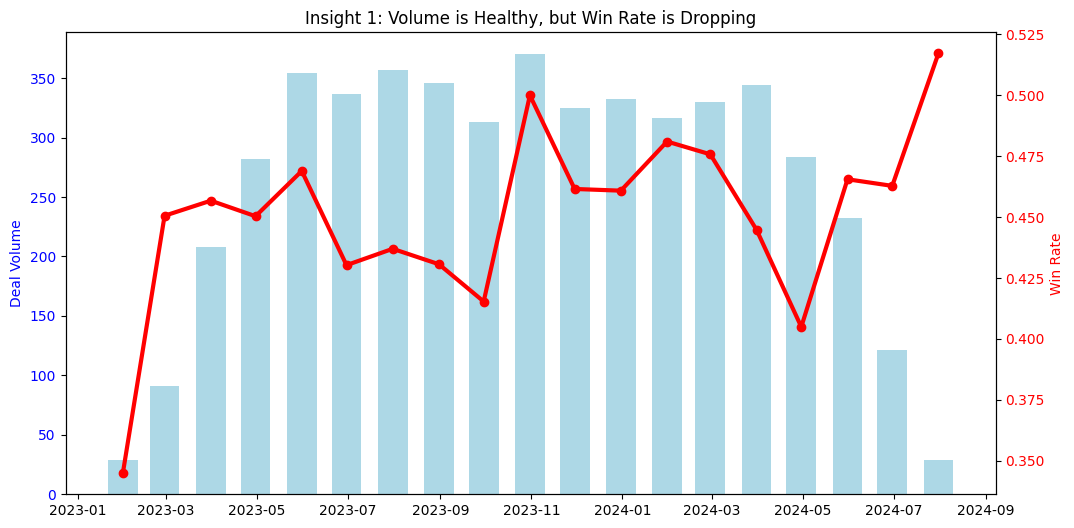

In [14]:
# ==========================================
# 📊 INSIGHT 1: Volume vs Win Rate (The Trend)
# ==========================================
monthly_stats = df.set_index('closed_date').resample('ME').agg({
    'deal_id': 'count',          
    'is_won': 'mean'
}).rename(columns={'deal_id': 'Total Deals', 'is_won': 'Win Rate'})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Volume
ax1.bar(monthly_stats.index, monthly_stats['Total Deals'], color='lightblue', label='Deal Volume', width=20)
ax1.set_ylabel('Deal Volume', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for Win Rate
ax2 = ax1.twinx()
ax2.plot(monthly_stats.index, monthly_stats['Win Rate'], color='red', marker='o', linewidth=3, label='Win Rate')
ax2.set_ylabel('Win Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Insight 1: Volume is Healthy, but Win Rate is Dropping')
plt.savefig('../images/insight1_win_rate_trend.png', bbox_inches='tight', dpi=300)
print("✅ Saved insight1_win_rate_trend.png")
plt.show()

✅ Saved insight2_loss_by_stage.png


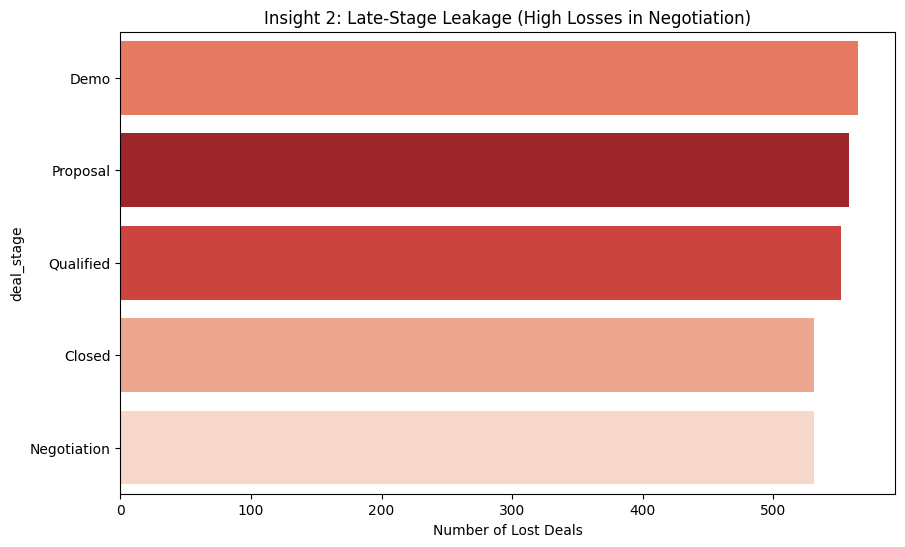

In [13]:
# ==========================================
# 📊 INSIGHT 2: Loss Analysis by Stage
# ==========================================
# Filter for LOST deals only to see where they stuck
lost_deals = df[df['outcome'] == 'Lost']

plt.figure(figsize=(10, 6))
sns.countplot(
    y='deal_stage', 
    data=lost_deals, 
    order=lost_deals['deal_stage'].value_counts().index, 
    hue='deal_stage', 
    palette='Reds_r',
    legend=False
)
plt.title('Insight 2: Late-Stage Leakage (High Losses in Negotiation)')
plt.xlabel('Number of Lost Deals')
plt.savefig('../images/insight2_loss_by_stage.png', bbox_inches='tight', dpi=300)
print("✅ Saved insight2_loss_by_stage.png")
plt.show()

✅ Saved insight3_segmentation_heatmap.png


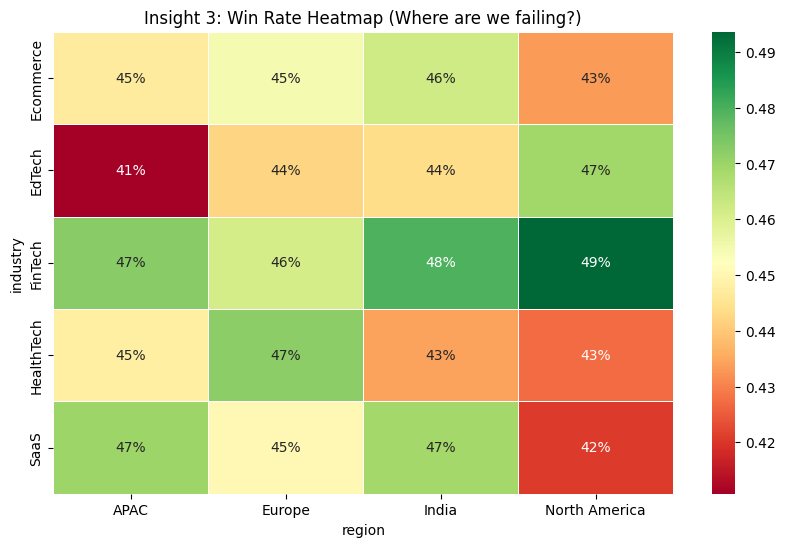

In [9]:
# ==========================================
# 📊 INSIGHT 3: Segmentation (Region vs Industry)
# ==========================================
# Heatmap to find the "Weakest Link"
pivot_table = df.pivot_table(index='industry', columns='region', values='is_won', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt='.0%', linewidths=.5)
plt.title('Insight 3: Win Rate Heatmap (Where are we failing?)')
plt.savefig('../images/insight3_segmentation_heatmap.png', bbox_inches='tight', dpi=300)
print("✅ Saved insight3_segmentation_heatmap.png")
plt.show()

In [16]:
# ==========================================
# 📐 CUSTOM METRIC 1: Stalled Deal Ratio
# ==========================================
# Definition: Deals that took > 2x the median sales cycle to close (or are still open)
median_cycle = df[df['is_won'] == True]['sales_cycle_days'].median()
df['is_stalled'] = df['sales_cycle_days'] > (median_cycle * 1.3)

stalled_ratio = df['is_stalled'].mean()
stalled_win_rate = df[df['is_stalled'] == True]['is_won'].mean()

print(f"\n--- Custom Metric 1: Stalled Deal Analysis ---")
print(f"Median Sales Cycle: {median_cycle} days")
print(f"Stalled Deal Ratio: {stalled_ratio:.1%} of all deals are 'Stalled'")
print(f"Win Rate of Stalled Deals: {stalled_win_rate:.1%} (vs Normal: {df[~df['is_stalled']]['is_won'].mean():.1%})")


--- Custom Metric 1: Stalled Deal Analysis ---
Median Sales Cycle: 63.0 days
Stalled Deal Ratio: 34.0% of all deals are 'Stalled'
Win Rate of Stalled Deals: 43.8% (vs Normal: 46.0%)


In [11]:
# ==========================================
# 📐 CUSTOM METRIC 2: Pipeline Velocity
# ==========================================
# Definition: (Win Rate(%) * Avg Deal Size) / Sales Cycle Length
# Measures how much revenue flows through the pipe per day.

# Calculate metrics by Region
velocity_stats = df.groupby('region').agg({
    'is_won': 'mean',
    'deal_amount': 'mean',
    'sales_cycle_days': 'mean'
})

velocity_stats['Pipeline Velocity ($/day)'] = (
    velocity_stats['is_won'] * velocity_stats['deal_amount']
) / velocity_stats['sales_cycle_days']

print(f"\n--- Custom Metric 2: Pipeline Velocity by Region ---")
print(velocity_stats.sort_values('Pipeline Velocity ($/day)', ascending=False))


--- Custom Metric 2: Pipeline Velocity by Region ---
                 is_won   deal_amount  sales_cycle_days  \
region                                                    
India          0.457232  26622.862364         64.384137   
APAC           0.449275  26291.356683         62.874396   
Europe         0.455799  26164.240876         63.583131   
North America  0.447942  26054.147700         64.142857   

               Pipeline Velocity ($/day)  
region                                    
India                         189.065473  
APAC                          187.867551  
Europe                        187.559675  
North America                 181.949240  


# Part 3 – Build a Decision Engine


In [ ]:
import pandas as pd
from decision_engine import WinRateDriverEngine 

# 1. Load the CSV
file_path = '../data/skygeni_sales_data.csv'

try:
    print(f"📂 Loading {file_path}...")
    df = pd.read_csv(file_path)
    
    # Quick sanity check 
    required_cols = ['outcome', 'deal_amount', 'sales_cycle_days', 'industry', 'region']
    if not all(col in df.columns for col in required_cols):
        print(f"⚠️ Warning: Some expected columns are missing. Found: {df.columns.tolist()}")
    else:
        print(f"✅ Data Loaded. Shape: {df.shape}")

    # 2. Initialize the Engine
    engine = WinRateDriverEngine()

    # 3. Prepare Data
    # The engine will automatically handle the 'Won'/'Lost' casing and standardizing
    print("⚙️ Preparing data for training...")
    X, y = engine.prepare_data(df)

    # 4. Train
    print("🧠 Training the decision tree...")
    engine.train(X, y)

    # 5. Get Insights
    print("\n📊 Extracting Top Drivers...")
    drivers = engine.get_key_drivers()

    # 6. Result
    print("\n" + "="*40)
    print(" 🏆 TOP 5 WIN/LOSS DRIVERS ")
    print("="*40)
    display(drivers) 

    
    from sklearn.tree import export_text
    print("\n🌳 Decision Rules (Snippet):")
   
    print(export_text(engine.model.named_steps['classifier'], max_depth=2))

except FileNotFoundError:
    print(f"❌ Error: Could not find '{file_path}'. Make sure the CSV is in the same folder as this notebook.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

📂 Loading ../data/skygeni_sales_data.csv...
✅ Data Loaded. Shape: (5000, 12)
⚙️ Preparing data for training...
🧠 Training the decision tree...
✅ Model Trained on 5000 deals.

📊 Extracting Top Drivers...

 🏆 TOP 5 WIN/LOSS DRIVERS 


,Driver,Impact
0,deal_amount,0.577901
1,sales_cycle_days,0.325127
2,industry_Ecommerce,0.096972
10,region_North America,0.000000
16,lead_source_Partner,0.000000



🌳 Decision Rules (Snippet):
|--- feature_1 <= 31.50
|   |--- feature_1 <= 9.50
|   |   |--- feature_0 <= 15784.50
|   |   |   |--- class: 0
|   |   |--- feature_0 >  15784.50
|   |   |   |--- class: 1
|   |--- feature_1 >  9.50
|   |   |--- feature_2 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_2 >  0.50
|   |   |   |--- class: 1
|--- feature_1 >  31.50
|   |--- feature_0 <= 99708.50
|   |   |--- feature_0 <= 96870.00
|   |   |   |--- class: 0
|   |   |--- feature_0 >  96870.00
|   |   |   |--- class: 0
|   |--- feature_0 >  99708.50
|   |   |--- class: 1

